# ML_np16ng_30K

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
os.chdir('/content/drive/MyDrive/ait_research_experiments')

In [ ]:
# import os
# os.environ['http_proxy'] = 'http://192.41.170.23:3128'
# os.environ['https_proxy'] = 'http://192.41.170.23:3128'

In [3]:
import pandas as pd
import os
import time
import glob
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report

import numpy as np
from sklearn.model_selection import GridSearchCV, train_test_split, StratifiedKFold

In [18]:
size = '30K'
dataset = 'np16ng'
datapath = os.path.join(os.getcwd(), 'dataset', size)
modelspath = os.path.join(os.getcwd(), 'models')

train_path = os.path.join(datapath, f'{dataset}_{size}_train_nosw.csv')
valid_path = os.path.join(datapath, f'{dataset}_{size}_valid_nosw.csv')
test_path = os.path.join(datapath, f'{dataset}_{size}_test_nosw.csv')

columns = ['content', 'category', 'labels']
train_df = pd.read_csv(train_path)[columns]
valid_df = pd.read_csv(valid_path)[columns]
test_df = pd.read_csv(test_path)[columns]

In [5]:
ngram_range = (1, 4)
min_df = 10
max_df = 0.5
max_features = 2000

tfidf = TfidfVectorizer(encoding='utf-8', 
                        ngram_range=ngram_range, 
                        max_df=max_df, 
                        min_df=min_df, 
                        max_features=max_features, 
                        norm='l2', 
                        sublinear_tf=True,
                        lowercase=False, 
                        tokenizer=lambda x: x.split(' '))

In [6]:
X_train, X_valid, X_test = train_df.content, valid_df.content, test_df.content
y_train, y_valid, y_test = train_df.labels, valid_df.labels, test_df.labels
X_train.shape, y_train.shape, X_valid.shape, y_valid.shape, X_test.shape, y_test.shape

((19200,), (19200,), (2400,), (2400,), (2400,), (2400,))

In [20]:
%%time 
features_train = tfidf.fit_transform(X_train).toarray()
labels_train = y_train

features_valid = tfidf.transform(X_valid).toarray()
labels_valid = y_valid

features_test = tfidf.transform(X_test).toarray()
labels_test = y_test

features_train.shape, features_valid.shape, features_test.shape

CPU times: user 1min 17s, sys: 3.7 s, total: 1min 21s
Wall time: 1min 21s


((19200, 2000), (2400, 2000), (2400, 2000))

In [21]:
categories = train_df.category.unique()
labels = train_df.labels.unique()

label2id = {}
for category, label in zip(categories, labels):
    label2id[category] = label
id2label = {v: k for k, v in label2id.items()}

target_names = np.sort(list(label2id.keys()))

In [9]:
def create_confusion_matrix(y_true, y_pred, title):
    data = {'y_true': y_true, 'y_pred': y_pred}
    df = pd.DataFrame(data, columns=['y_true', 'y_pred'])

    df.y_true = df.y_true.map(id2label)
    df.y_pred = df.y_pred.map(id2label)
    
    confusion_matrix = pd.crosstab(df['y_true'], df['y_pred'], rownames=['Actual Category'], colnames=['Predicted Category'])
    
    fig = plt.figure(figsize=(10, 7))
    sns.heatmap(confusion_matrix, annot=True, cmap='Blues', fmt='g').set_title(title)

## Using Nested CV for MNB, RF and SVM (data = 30K)

In [22]:
start_time = time.time()

OUTER_FOLDS = 5
INNER_FOLDS = 3

# Initializing Classifiers
clf_mnb = MultinomialNB()
clf_rf = RandomForestClassifier()
clf_svm = SVC()

# Setting up the parameter grids
param_grid_mnb = {
    'alpha': [1, 0.1, 0.01, 0.001],
}

param_grid_rf = {
    'max_depth': [200, 300],
    'n_estimators': [500, 1000]
}

param_grid_svm = [{
    'kernel': ['rbf'],
    'C': [ 10, 50, 100],
    'gamma': [1, 0.1]
}]

# Setting up GridSearchCV objects
gridcvs = {}
inner_cv = StratifiedKFold(n_splits=INNER_FOLDS, shuffle=True, random_state=44)

for pgrid, clf, name in zip((param_grid_mnb, param_grid_rf, param_grid_svm),
                           (clf_mnb, clf_rf, clf_svm),
                           ('MultinomialNaiveBayes', 'RandomForest', 'SVM')):
    gcv = GridSearchCV(estimator=clf, 
                       param_grid=pgrid, 
                       scoring='accuracy', 
                       n_jobs=-1, 
                       cv=inner_cv, 
                       verbose=0, 
                       refit=True)
    
    gridcvs[name] = gcv
    

for name, gs_est in sorted(gridcvs.items()):
    print(50 * '-', '\n')
    print('Algorithm: ', name)
    # print('    Inner loop:')
    
    outer_scores = []
    outer_cv = StratifiedKFold(n_splits=OUTER_FOLDS, shuffle=True, random_state=44)
    
    for train_idx, valid_idx in outer_cv.split(features_train, labels_train):
        
        print('\n  Outer Loop: ', len(outer_scores) + 1)
        gridcvs[name].fit(features_train[train_idx], labels_train[train_idx])
        print('        Best ACC (best of inner test folds) %.2f%%' % (gridcvs[name].best_score_ * 100))
        print('        Best parameters:', gridcvs[name].best_params_)
        print('        Best estimator:', gridcvs[name].best_estimator_)
        print('        Best estimator score (train_set):', gridcvs[name].best_estimator_.score(features_train[train_idx], labels_train[train_idx]))
        print('        Refit time:', gridcvs[name].refit_time_)
        
        outer_scores.append(gridcvs[name].best_estimator_.score(features_train[valid_idx], labels_train[valid_idx]))
        print('        ACC (on outer test fold) %.2f%%' % (outer_scores[-1]*100))
        
    print('\n    Outer Loop:')
    print('        ACC %.2f%% +/- %.2f' % (np.mean(outer_scores) * 100, np.std(outer_scores) * 100))
    
total_time = time.time() - start_time
print(f'\nTotal Execution time: {np.round(total_time, 3)} seconds')

-------------------------------------------------- 

Algorithm:  MultinomialNaiveBayes

  Outer Loop:  1
        Best ACC (best of inner test folds) 81.12%
        Best parameters: {'alpha': 0.1}
        Best estimator: MultinomialNB(alpha=0.1)
        Best estimator score (train_set): 0.8352864583333334
        Refit time: 0.09289026260375977
        ACC (on outer test fold) 81.46%

  Outer Loop:  2
        Best ACC (best of inner test folds) 81.23%
        Best parameters: {'alpha': 0.1}
        Best estimator: MultinomialNB(alpha=0.1)
        Best estimator score (train_set): 0.8341145833333333
        Refit time: 0.0896914005279541
        ACC (on outer test fold) 81.35%

  Outer Loop:  3
        Best ACC (best of inner test folds) 81.01%
        Best parameters: {'alpha': 0.01}
        Best estimator: MultinomialNB(alpha=0.01)
        Best estimator score (train_set): 0.8372395833333334
        Refit time: 0.08701872825622559
        ACC (on outer test fold) 81.88%

  Outer Loop: 

/usr/local/lib/python3.7/dist-packages/joblib/externals/loky/process_executor.py:703: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


        Best ACC (best of inner test folds) 82.83%
        Best parameters: {'max_depth': 200, 'n_estimators': 500}
        Best estimator: RandomForestClassifier(max_depth=200, n_estimators=500)
        Best estimator score (train_set): 0.9999348958333333
        Refit time: 148.77232003211975
        ACC (on outer test fold) 83.36%

  Outer Loop:  2
        Best ACC (best of inner test folds) 82.94%
        Best parameters: {'max_depth': 300, 'n_estimators': 1000}
        Best estimator: RandomForestClassifier(max_depth=300, n_estimators=1000)
        Best estimator score (train_set): 1.0
        Refit time: 306.7446711063385
        ACC (on outer test fold) 83.52%

  Outer Loop:  3


/usr/local/lib/python3.7/dist-packages/joblib/externals/loky/process_executor.py:703: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


        Best ACC (best of inner test folds) 82.74%
        Best parameters: {'max_depth': 200, 'n_estimators': 1000}
        Best estimator: RandomForestClassifier(max_depth=200, n_estimators=1000)
        Best estimator score (train_set): 0.9999348958333333
        Refit time: 316.2406060695648
        ACC (on outer test fold) 84.09%

  Outer Loop:  4


/usr/local/lib/python3.7/dist-packages/joblib/externals/loky/process_executor.py:703: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


        Best ACC (best of inner test folds) 82.90%
        Best parameters: {'max_depth': 200, 'n_estimators': 1000}
        Best estimator: RandomForestClassifier(max_depth=200, n_estimators=1000)
        Best estimator score (train_set): 0.9999348958333333
        Refit time: 315.3173990249634
        ACC (on outer test fold) 83.33%

  Outer Loop:  5


/usr/local/lib/python3.7/dist-packages/joblib/externals/loky/process_executor.py:703: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


        Best ACC (best of inner test folds) 82.74%
        Best parameters: {'max_depth': 300, 'n_estimators': 500}
        Best estimator: RandomForestClassifier(max_depth=300, n_estimators=500)
        Best estimator score (train_set): 1.0
        Refit time: 162.11773204803467
        ACC (on outer test fold) 83.57%

    Outer Loop:
        ACC 83.57% +/- 0.27
-------------------------------------------------- 

Algorithm:  SVM

  Outer Loop:  1
        Best ACC (best of inner test folds) 86.61%
        Best parameters: {'C': 10, 'gamma': 1, 'kernel': 'rbf'}
        Best estimator: SVC(C=10, gamma=1)
        Best estimator score (train_set): 0.9998697916666667
        Refit time: 282.37886238098145
        ACC (on outer test fold) 87.29%

  Outer Loop:  2
        Best ACC (best of inner test folds) 86.87%
        Best parameters: {'C': 10, 'gamma': 1, 'kernel': 'rbf'}
        Best estimator: SVC(C=10, gamma=1)
        Best estimator score (train_set): 1.0
        Refit time: 315.446

## Multinomial Naive Bayes

Validation Accuracy:  0.80625
               precision    recall  f1-score   support

         Arts       0.73      0.68      0.70       150
   Automobile       0.81      0.85      0.83       150
         Bank       0.70      0.71      0.71       150
        Crime       0.88      0.94      0.91       150
    Education       0.83      0.93      0.87       150
   Employment       0.85      0.79      0.82       150
Entertainment       0.85      0.70      0.77       150
       Health       0.80      0.63      0.70       150
    Lifestyle       0.73      0.92      0.82       150
   Literature       0.73      0.85      0.79       150
       Market       0.72      0.59      0.65       150
     Politics       0.87      0.93      0.90       150
       Sports       0.96      0.91      0.94       150
   Technology       0.86      0.79      0.82       150
      Tourism       0.82      0.89      0.85       150
        World       0.78      0.81      0.79       150

     accuracy                    

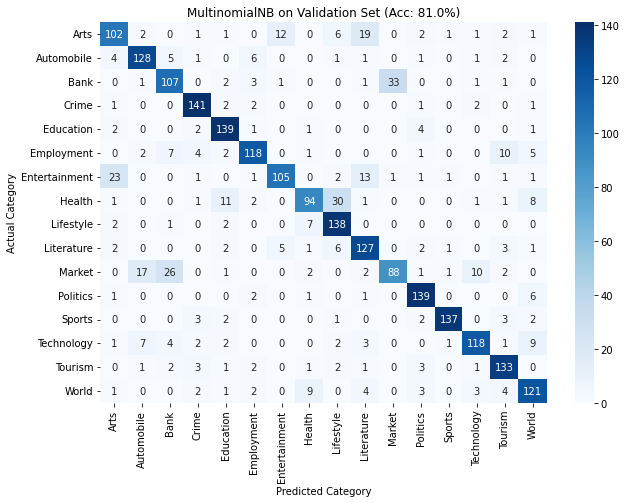

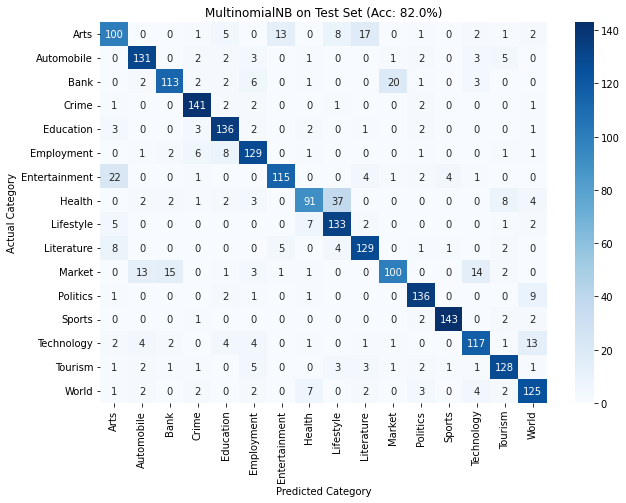

In [23]:
mnb_model = MultinomialNB(alpha=0.1)
mnb_model.fit(features_train, labels_train)

model_predictions_valid = mnb_model.predict(features_valid)
print('Validation Accuracy: ', accuracy_score(labels_valid, model_predictions_valid))
print(classification_report(labels_valid, model_predictions_valid, target_names=np.sort(list(label2id.keys()))))
create_confusion_matrix(labels_valid, model_predictions_valid, f'MultinomialNB on Validation Set (Acc: {round(accuracy_score(labels_valid, model_predictions_valid), 2) * 100}%)')

model_predictions_test = mnb_model.predict(features_test)
print('Test Accuracy: ', accuracy_score(labels_test, model_predictions_test))
print(classification_report(labels_test, model_predictions_test, target_names=np.sort(list(label2id.keys()))))
create_confusion_matrix(labels_test, model_predictions_test, f'MultinomialNB on Test Set (Acc: {round(accuracy_score(labels_test, model_predictions_test), 2) * 100 }%)')

## Random Forest

Validation Accuracy:  0.8433333333333334
               precision    recall  f1-score   support

         Arts       0.76      0.81      0.78       150
   Automobile       0.90      0.88      0.89       150
         Bank       0.80      0.86      0.83       150
        Crime       0.85      0.94      0.90       150
    Education       0.89      0.95      0.92       150
   Employment       0.91      0.79      0.85       150
Entertainment       0.88      0.72      0.79       150
       Health       0.78      0.79      0.79       150
    Lifestyle       0.82      0.90      0.86       150
   Literature       0.81      0.83      0.82       150
       Market       0.79      0.73      0.76       150
     Politics       0.88      0.91      0.90       150
       Sports       0.93      0.95      0.94       150
   Technology       0.87      0.77      0.82       150
      Tourism       0.84      0.89      0.86       150
        World       0.82      0.75      0.78       150

     accuracy         

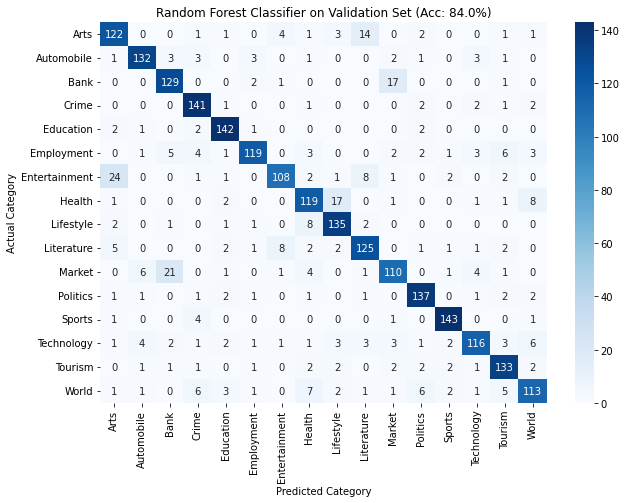

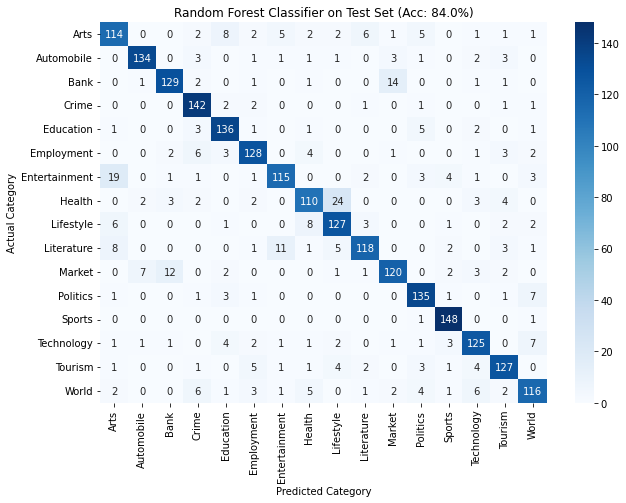

In [24]:
rf_model = RandomForestClassifier(max_depth=200, n_estimators=1000)

rf_model.fit(features_train, labels_train)

model_predictions_valid = rf_model.predict(features_valid)
print('Validation Accuracy: ', accuracy_score(labels_valid, model_predictions_valid))
print(classification_report(labels_valid, model_predictions_valid, target_names=np.sort(list(label2id.keys()))))
create_confusion_matrix(labels_valid, model_predictions_valid, f'Random Forest Classifier on Validation Set (Acc: {round(accuracy_score(labels_valid, model_predictions_valid), 2) * 100}%)')

model_predictions_test = rf_model.predict(features_test)
print('Test Accuracy: ', accuracy_score(labels_test, model_predictions_test))
print(classification_report(labels_test, model_predictions_test, target_names=np.sort(list(label2id.keys()))))
create_confusion_matrix(labels_test, model_predictions_test, f'Random Forest Classifier on Test Set (Acc: {round(accuracy_score(labels_test, model_predictions_test), 2) * 100 }%)')

## SVM

Validation Accuracy:  0.8670833333333333
               precision    recall  f1-score   support

         Arts       0.78      0.79      0.79       150
   Automobile       0.90      0.92      0.91       150
         Bank       0.79      0.84      0.82       150
        Crime       0.92      0.95      0.93       150
    Education       0.93      0.93      0.93       150
   Employment       0.89      0.83      0.86       150
Entertainment       0.86      0.75      0.80       150
       Health       0.80      0.81      0.80       150
    Lifestyle       0.91      0.90      0.90       150
   Literature       0.81      0.88      0.84       150
       Market       0.81      0.77      0.79       150
     Politics       0.92      0.93      0.93       150
       Sports       0.97      0.96      0.97       150
   Technology       0.87      0.84      0.85       150
      Tourism       0.87      0.93      0.90       150
        World       0.85      0.85      0.85       150

     accuracy         

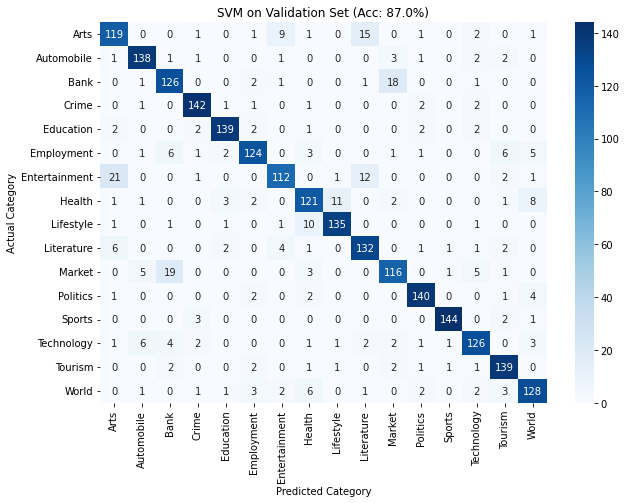

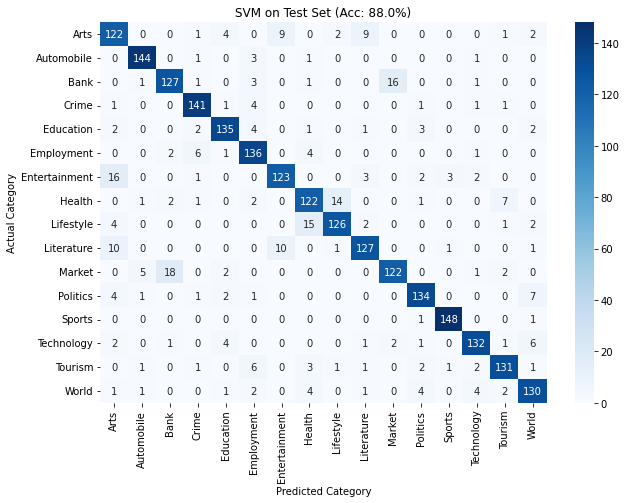

In [25]:
svm_model = SVC(C=10, gamma=1)
svm_model.fit(features_train, labels_train)

model_predictions_valid = svm_model.predict(features_valid)
print('Validation Accuracy: ', accuracy_score(labels_valid, model_predictions_valid))
print(classification_report(labels_valid, model_predictions_valid, target_names=np.sort(list(label2id.keys()))))
create_confusion_matrix(labels_valid, model_predictions_valid, f'SVM on Validation Set (Acc: {round(accuracy_score(labels_valid, model_predictions_valid), 2) * 100}%)')

model_predictions_test = svm_model.predict(features_test)
print('Test Accuracy: ', accuracy_score(labels_test, model_predictions_test))
print(classification_report(labels_test, model_predictions_test, target_names=np.sort(list(label2id.keys()))))
create_confusion_matrix(labels_test, model_predictions_test, f'SVM on Test Set (Acc: {round(accuracy_score(labels_test, model_predictions_test), 2) * 100 }%)')